In [46]:
!pip install flax
%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
!pip install colorama


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
import jax
import jax.numpy as jnp                # JAX NumPy

from flax import linen as nn           # The Linen API
from flax import traverse_util
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers
import matplotlib.pyplot as plt
import networkx as nx

def init_board():
  return np.zeros((3, 3), dtype=int).flatten()

def flip_board(board):
  return -board

def get_valid_mask(board):
  return board == 0

# #Always assume action is made by player 1
# def get_next_state(board, action):
#   return board.flatten().at[action].add(1).reshape(board.shape)

#Always assume action is made by player 1
#Assume action is valid
def get_next_state(board, action):
  if(board[action] == 1 or board[action] == -1):
    print("Illegal Move")
    print(board.reshape((3,3)))
    print(action)
    print(get_reward(board))
    assert False
  next_board = board.copy()
  next_board[action] = 1
  return next_board

def sample_action(action_dist):
  action_dist = action_dist.flatten() / action_dist.sum()
  return np.random.choice(action_dist.shape[0], p=action_dist)

def disp_board(board):
  plt.imshow(board)

In [49]:
diag_mask = np.eye(3)
ld_mask = np.eye(3)[::-1, :]
def get_reward(board): #Assume move and flip, so board can only be lost
    b = board.reshape((3,3))
    diag = np.sum(diag_mask*b) <= -3
    diag_l = np.sum(ld_mask*b) <= -3
    row = np.min(b@np.ones(3)) <= -3
    col = np.min(b.T@np.ones(3)) <= -3
    reward = -int(diag or diag_l or row or col)
    return reward, (reward != 0 or (board == 0).sum() == 0)


In [50]:
# RUNNING THIS CELL OVERWRITES THE ABOVE TICTACTOE FUNCTIONS WITH THEIR AZUL COUNTERPARTS
import Azul_Simulator
rng_azul = np.random.default_rng(6546547)

def azul_init_board():
  return Azul_Simulator.init_board(rng_azul)

def azul_get_next_state(board, action):
  return Azul_Simulator.get_next_state(board, action, rng_azul)

init_board = azul_init_board
flip_board = Azul_Simulator.flip_board
get_valid_mask = Azul_Simulator.get_valid_mask
get_next_state = azul_get_next_state
get_reward = Azul_Simulator.get_reward
disp_board = Azul_Simulator.disp_board

In [51]:
# rng = jax.random.PRNGKey(40)
for i in range(200):
  board = init_board()
  for i in range(100):
    # _, rng = jax.random.split(rng, 2)
    action_dist = np.ones(181) * get_valid_mask(board)
    next_action = sample_action(action_dist)
    # print(board.reshape((3,3)), next_action)
    board = flip_board(get_next_state(board, next_action))
    reward, game_over = get_reward(board)
    if(game_over):
      break
#print(board.reshape((3, 3)), reward, game_over)

In [52]:
def toy_model(state):
    return np.ones(ACTION_DIM) / ACTION_DIM, 0.1

In [53]:
arr = np.zeros(10, dtype=int)
a = arr.dtype
print(a)
print(np.all(arr==0))

int64
True


In [54]:
STATE_DIM = 157
ACTION_DIM = 181
MAX_SIZE = int(1e3)
C_BASE, C_INIT = 1.0, 1.0
class MCTS:
    def __init__(self, max_size=MAX_SIZE):
        self.state = np.zeros((max_size, STATE_DIM), dtype=int)
        self.state_lookup = {} #Maps state representation to index
        self.expanded = []

        self.visit_count = np.zeros(max_size, dtype=int)
        self.action_visits  = np.zeros((max_size, ACTION_DIM), dtype=int)
        self.action_total_value = np.zeros((max_size, ACTION_DIM))
        self.action_mean_value = np.zeros((max_size, ACTION_DIM))
        self.action_prior = np.zeros((max_size, ACTION_DIM))
        # self.action_children = np.zeros((MAX_SIZE, ACTION_DIM), dtype=int) - 1
    
    #Assumes state is already expanded, and uses MCTS info to pick best action
    def select_action(self, state, state_index):
        state_visits = self.visit_count[state_index]
        exp_rate = np.log((1+state_visits + C_BASE)/C_BASE) + C_INIT
        model_prior = self.action_prior[state_index]
        sa_visits = self.action_visits[state_index]
        sa_mean_value = (1+self.action_mean_value[state_index])/2 #Normalize to [0, 1]
        action_distr = (sa_mean_value + exp_rate*np.sqrt(state_visits)*model_prior/(1+sa_visits))*get_valid_mask(state)
        action = np.argmax(action_distr)
        # print(state[action])
        if get_valid_mask(state)[action] == 0:
            print("State:")
            # disp_board(state)
            print(state)
            print(self.state[state_index])
            # bad_state = state
            print("action", action)
            print("exp rate", exp_rate)
            print("sa mean value", sa_mean_value, sa_visits)
            print("action distr", action_distr)
            print("model prior", model_prior)
            print("action_mask", get_valid_mask(state))
            print("state index", state_index)
            print("visit_count", self.visit_count[state_index])

        return action

    def get_action_prob(self, state_index, temperature=1):
        """
        Select action according to the visit count distribution and the temperature.
        """
        action_visits = self.action_visits[state_index]
        if temperature == 0:
            a = np.argmax(action_visits)
            r = np.zeros(action_visits.shape)
            r[a] = 1.0
            return r
        elif temperature == float("inf"):
            return np.ones(action_visits.shape)/action_visits.shape[0]
        else:
            # See paper appendix Data Generation
            visit_count_distribution = np.power(action_visits, 1 / temperature)
            visit_count_distribution = visit_count_distribution / sum(visit_count_distribution)
            return visit_count_distribution
            
    def expand_node(self, state, action_weights):
        state_index = len(self.expanded)
        self.expanded.append(True)
        self.state_lookup[state.tobytes()] = state_index

        self.state[state_index] = state
        self.visit_count[state_index] += 1

        valid_moves = get_valid_mask(state)
        action_probs = (action_weights + 1e-6) * valid_moves  # mask invalid moves
        action_probs /= np.sum(action_probs)

        if(not np.any(valid_moves)):
            print("No valid moves")
        if(np.any(np.isnan(action_probs))):
            print("action probs set to nan for", state_index)
            print("state", state)
            print("action weights", action_weights)
            print("unnorm weights", (action_weights + 1e-6) * valid_moves)

        self.action_prior[state_index] = action_probs
        return state_index

    def search_iter(self, state_index, model):
        search_path = []
        path_actions = []

        curr_index = state_index
        curr_state = self.state[state_index]

        # Loop until reaching an untracked state
        while curr_index >= 0:
            search_path.append(curr_index)
            action = self.select_action(curr_state, curr_index)
            path_actions.append(action)
            curr_state = flip_board(get_next_state(curr_state, action))
            nsr = curr_state.tobytes()
            if(nsr in self.state_lookup):
                curr_index = self.state_lookup[nsr]
            else:
                curr_index = -1

        # The value of the new state from the perspective of the other player
        next_state = curr_state
        value, game_over = get_reward(next_state)
        value = -value
        if not game_over:
            # If the game has not ended:
            # EXPAND
            action_probs, value = model(next_state)
            self.expand_node(next_state, action_probs)
        
        #Backpropagate MCTS search path
        for i in range(len(search_path)-1, -1, -1):
            si, a = search_path[i], path_actions[i]
            self.visit_count[si] += 1
            self.action_visits[si, a] += 1
            self.action_total_value[si, a] += value
            self.action_mean_value[si, a] = self.action_total_value[si, a] / self.action_visits[si, a]
            value *= -1

        # print("search path", search_path)
        # print("search visits after update", [self.visit_count[s] for s in search_path])
        
    def mcts_eval(self, state, model, num_sims):
        # print("Expanded len", len(self.expanded))
        if(np.any(np.isnan(state))):
            print("Nan detected")
            print(state)
        root_state = state
        action_prior, value_est = model(root_state)
        root_index = self.expand_node(root_state, action_prior)
        # print("Root index", root_index)
        for _ in range(num_sims):
            self.search_iter(root_index, model)
        return root_index
    
    def print_tree(self, root_index=0):
        for state_index in self.state_lookup.values():
            state = self.state[state_index]
            #print(state.reshape((3, 3))) # CHANGED!
            visited_actions = self.action_visits[state_index].nonzero()[0]
            action_values = self.action_mean_value[state_index, visited_actions]
            print("Action", visited_actions)
            print("Action value", action_values)

    def visualize_tree(self, root_index, depth=100):
        G = nx.Graph()
        node_labels = {}
        edge_labels = {}
        for state_index in self.state_lookup.values():
            visited_actions = self.action_visits[state_index].nonzero()[0]
            action_values = self.action_mean_value[state_index, visited_actions]
            state = self.state[state_index]
            for action, value in zip(visited_actions, action_values):
                child_state = flip_board(get_next_state(state, action))
                # print(child_state.reshape((4,4)))
                child_index = self.state_lookup[child_state.tobytes()]
                G.add_edge(state_index, child_index)
                edge_labels[(state_index, child_index)] = value
            node_labels[state_index] = f"{state_index}, {self.action_visits[state_index].sum()}" 
        
        pos = nx.spring_layout(G)
        plt.figure()
        nx.draw(
            G, pos, edge_color='black', width=1, linewidths=1, node_size=10, 
            node_color='pink', alpha=0.9,
            # labels=node_labels
        )
        # nx.draw_networkx_edge_labels(
        #     G, pos,
        #     edge_labels=edge_labels,
        #     font_color='red'
        # )
        plt.axis('off')
        plt.show()

# root_state = np.array([-1, 1, 0, 0, 0, 0, -1, 1, 0])
# print(root_state.reshape((3, 3)))
# root_state[:2] = 1
root_state = init_board() # CHANGED!
mcts = MCTS(max_size=5001)
mcts.mcts_eval(root_state, toy_model, 5000)
print("Finished mcts")
# mcts.visualize_tree()

Finished mcts


In [55]:
for i, state in enumerate(mcts.state[:5001]):
    if(np.all(state == 0)):
        print(i, state)

In [56]:
def self_play_episode(model, num_sims=50, temp_threshold=6):
    train_examples = []
    board = init_board()
    step = 0
    while True:
        if(board.dtype != np.int64):
            print("Incorrect type")
        mcts = MCTS(max_size=1001)
        root_index = mcts.mcts_eval(board, model, num_sims=num_sims)
        # print(root_index, mcts.state[root_index].reshape((3,3)))
        # print(board.reshape((3,3)))
        # print(mcts.state[0].reshape((3,3)))
        # print(mcts.action_visits[0].reshape((3,3)))
        
        temp = int(step < temp_threshold)
        pi = mcts.get_action_prob(root_index, temperature=temp)


        train_examples.append((board, pi, step))

        action = np.random.choice(ACTION_DIM, p=pi)
        # print("action", action)

        board = flip_board(get_next_state(board.astype(int), action))
        #Reward is always negative because board is flipped after move. 
        r, game_over = get_reward(board) 
        if(game_over):
            return [(b, p, (-1)**(step-s)) for b, p, s in train_examples]
        step += 1

def batch_examples(train_examples):
    state_batch = jnp.stack([t[0] for t in train_examples])
    pa_batch = jnp.stack([t[1] for t in train_examples])
    r_batch = jnp.stack([t[2] for t in train_examples]).reshape((-1, 1))
    return state_batch, pa_batch, r_batch

train_examples = self_play_episode(toy_model, num_sims=100)
state_b, pa_b, r_b = batch_examples(train_examples)

In [57]:
from jax import jit

class TTTModel(nn.Module):
  """A simple MLP model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=64)(x)
    body = nn.Dense(features=32)(x)
    x = nn.Dense(features=181)(body)
    value = nn.tanh(nn.Dense(features=1)(body)) #Value estimate between -1 and 1
    return x, value

@jit
def model_agent(x, params):
  logits, value = TTTModel().apply(params, x)
  return nn.softmax(logits), value

model = TTTModel()
rng = jax.random.PRNGKey(42)
params = model.init(rng, init_board())
# model.apply(params, state_b)[1].shape
# model_agent(state_b, params)

In [58]:
def create_train_state(rng, learning_rate, momentum):
  """Creates initial `TrainState`."""
  model = TTTModel()
  params = model.init(rng, jnp.array(init_board()))['params']

  tx = optax.sgd(learning_rate, momentum)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, state_b, pa_b, r_b):
  """Train for a single step."""
  def loss_fn(params):
    logits, exp_value = TTTModel().apply({'params': params}, state_b)
    loss = optax.softmax_cross_entropy(logits, pa_b).mean() + jnp.square(r_b - exp_value).mean()
    return loss, (logits, exp_value)
  grad_fn = jax.grad(loss_fn, has_aux=True)
  grads, aux = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  # metrics = compute_metrics(logits=logits, labels=batch['label'])
  return state#, metrics

# state = train_step(state, state_b, pa_b, r_b)

In [59]:
rng_azul = np.random.default_rng(6546547)
state = create_train_state(rng, 0.01, 0.1)
for i in range(100):
    print(f"Batch {i}")
    train_examples = self_play_episode(lambda x: model_agent(x, {'params': state.params}))
    state_b, pa_b, r_b = batch_examples(train_examples)
    state = train_step(state, state_b, pa_b, r_b)

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99


In [60]:
board_state = """0  0  0  0 17 17 15 16 15  0  0  0  0  0  1  0  2  1  0  0  0  2  1  1
  1  0  0  0  3  1  2  0  1  0  0  1  1  1  1  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0"""
board_state = np.array([int(x) for x in board_state.split()])
print(board_state)

[ 0  0  0  0 17 17 15 16 15  0  0  0  0  0  1  0  2  1  0  0  0  2  1  1
  1  0  0  0  3  1  2  0  1  0  0  1  1  1  1  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
print(state.params)

FrozenDict({
    Dense_0: {
        bias: DeviceArray([ 7.5539996e-05, -2.6229705e-04,  2.5983555e-03,
                     -4.8310179e-03, -6.4433562e-03, -3.2961060e-04,
                      7.9944066e-04,  1.2149708e-03,  9.0993359e-04,
                      2.0591991e-03,  9.2540222e-04,  6.2503228e-03,
                     -1.0938551e-03, -5.1829522e-04, -3.5864476e-03,
                     -4.0514045e-03,  1.9058562e-03, -4.6052770e-03,
                      5.7108528e-03, -1.9058277e-03, -1.8281526e-03,
                     -1.2033298e-03, -2.6344068e-04,  2.1659907e-04,
                     -1.1286947e-03, -1.1178273e-03,  2.7374672e-03,
                      3.9411386e-04,  1.0078683e-03, -6.1713008e-04,
                      1.9626178e-04,  3.6481561e-03, -3.8246383e-04,
                      8.3331414e-04,  3.9687715e-03,  1.1868543e-03,
                      3.0341882e-03, -3.4531292e-03,  6.1419769e-04,
                      7.2831719e-04, -7.0990680e-04, -2.5086561e-03,


In [ ]:
prior, reward = model_agent(board_state, {'params': state.params})
print(prior)

[6.61972212e-04 1.06882646e-04 9.58195415e-06 8.19484144e-03
 1.64499608e-04 1.54667541e-05 1.01093046e-01 9.83312377e-04
 8.61460716e-03 2.27564131e-04 1.03530613e-06 3.64517095e-04
 2.52952403e-03 1.96044450e-04 2.52433674e-04 8.65959302e-02
 1.03253487e-05 5.05524667e-06 2.00281829e-05 3.28899114e-06
 1.07863525e-04 8.69145035e-04 5.29986247e-03 2.56957747e-02
 3.89611840e-01 1.56102498e-04 5.83242141e-02 3.14369281e-05
 6.59584475e-04 7.73228930e-06 4.50158678e-02 4.60651063e-05
 7.06055216e-05 1.12472022e-04 5.84513546e-05 1.01297868e-04
 7.59194465e-03 1.92786218e-04 3.28425522e-04 3.95769166e-05
 1.05270406e-03 8.32417209e-05 4.63876757e-04 1.69036889e-06
 3.13826822e-05 1.93583128e-05 2.40344182e-03 1.71101477e-04
 1.81405721e-05 6.94271759e-04 2.46572999e-05 1.66971498e-04
 1.76833849e-03 3.76397953e-03 1.89580460e-04 8.06832613e-05
 4.92503477e-06 4.02021396e-04 7.22189652e-05 1.72823656e-03
 6.47895940e-05 2.08207942e-03 6.41796651e-05 8.77270504e-05
 1.36095172e-04 1.923387

In [ ]:
print(prior.max(), prior.min())

0.3578067 2.2307382e-12


In [61]:
"""board = np.array([1, -1, 0, -1, 1, 0, -1, 0, -1])
# board = np.zeros_like(board)
print(board.reshape((3,3)))
model = TTTModel()
action_prior, value = model.apply({'params': state.params}, board)
print(action_prior.reshape((3,3)), value)"""

def learned_agent(board):
    prior = model_agent(board, {'params': state.params})[0]
    prior *= get_valid_mask(board)
    return np.argmax(prior)

def random_agent(board):
    valid_mask = np.float32(get_valid_mask(board))
    if valid_mask.sum() == 0:
      print(board)
      print(valid_mask)
    valid_mask /= valid_mask.sum()
    return np.random.choice(181, p=valid_mask)

Completed 0 matches.
Completed 100 matches.
Completed 200 matches.
Completed 300 matches.
Completed 400 matches.
Completed 500 matches.
Completed 600 matches.
Completed 700 matches.
Completed 800 matches.
Completed 900 matches.


(array([257.,   8., 735.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <a list of 3 Patch objects>)

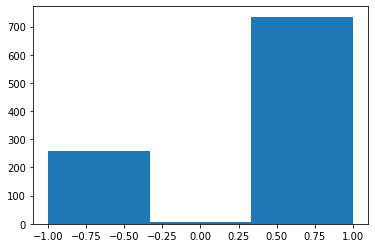

In [62]:
def play_match(agent1, agent2):
    board = init_board()
    agents = [agent1, agent2]
    step = 0
    while True:
        a = agents[step%2](board)
        board = flip_board(get_next_state(board, a))
        reward, game_over = get_reward(board)
        # print(step, board)
        if(game_over):
            return reward**step
        step += 1

match_results = []
for i in range(1000):
    if i % 100 == 0:
      print("Completed " + str(i) + " matches.")
    match_results.append(play_match(learned_agent, random_agent))
plt.hist(match_results, bins=3)

(array([245.,   0.,   0.,   0.,   0.,  10.,   0.,   0.,   0., 745.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

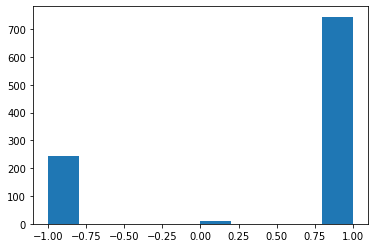

In [63]:
match_results = []
for i in range(1000):
    match_results.append(play_match(random_agent, random_agent))
plt.hist(match_results)

In [65]:
print("Welcome to the Azul Simulator!")
print()
board = azul_init_board()
disp_board(board)
print()
computer_turn = False
end = False

while not end:
    if computer_turn:
        print("Computer's turn...")
    else:
        print("Player's turn...")
    print("Enter a move: ")
    
    # Flip the state to put all player data in the current player section
    if not computer_turn:
        board = flip_board(board)
        invalid_action_or_input = True

        while invalid_action_or_input:
            input_string = input()
            board, error = Azul_Simulator.take_action_from_string(board, input_string, rng_azul)

            # Validate input_string
            if error:
                print("Enter a different move: ")
                continue
            invalid_action_or_input = False
        board = flip_board(board)
    else:
        action = learned_agent(board)
        board = get_next_state(board, action)

    reward, end = get_reward(board)
    if end and reward == -1:
        print()
        print("Computer wins!!!")
        break
    elif end and reward == 1:
        print()
        print("Player wins!!!")
        break

    disp_board(board)

    if board[Azul_Simulator.State_Indices.NOOP.value] == 1:
        board = get_next_state(board, Azul_Simulator.Action_Indices.NOOP.value)
    else:
        computer_turn = not computer_turn

Welcome to the Azul Simulator!

##############################################
TABLE:
----------------------------------------------
Center:     *1*                     (no BYRDW)
Factory #1: YRDW                    (no B)
Factory #2: BYDW                    (no R)
Factory #3: BYRD                    (no W)
Factory #4: BRRW                    (no YD)
Factory #5: BDWW                    (no YR)
----------------------------------------------

COMPUTER: (score - 0)
----------------------------------------------
        _  | B Y R D W 
      _ _  | W B Y R D 
    _ _ _  | D W B Y R 
  _ _ _ _  | R D W B Y 
_ _ _ _ _  | Y R D W B 

Floor: 
----------------------------------------------

PLAYER: (score - 0)
----------------------------------------------
        _  | B Y R D W 
      _ _  | W B Y R D 
    _ _ _  | D W B Y R 
  _ _ _ _  | R D W B Y 
_ _ _ _ _  | Y R D W B 

Floor: 
----------------------------------------------
##############################################

Player's turn...
E

AttributeError: ignored